# Predviđanje vrste i kvaliteta vina iz njegovih fizičkih svojstava

Kvalitet vina je ključan za konzumere kao i za proizvođače u vinskoj industriji. Sertifikacija kvaliteta proizvoda postaje sve važnija za povećanje tržišne vrednosti i prodaje. Tradicionalno, testiranje kvaliteta vina vrši se na kraju proizvodnog procesa, što je vremenski zahtevno i resursno intenzivno. Ovaj pristup zahteva angažovanje brojnih stručnjaka za procenu, što može biti skupo i subjektivno, s obzirom na različite mišljenja i standarde procene.

Kako bi se poboljšala efikasnost i tačnost u proceni kvaliteta vina, možemo koristiti objektivne metode koje mogu smanjiti zavisnost od ljudskih procena. Različite karakteristike vina mogu uticati na njegov kvalitet, ali nisu sve od njih relevantne za precizno predviđanje. 
U ovom projektu koristimo mašinsko učenje da bismo identifikovali ključne karakteristike vina i omogućili preciznije i efikasnije ocenjivanje njegovog kvaliteta.

## Skup podataka
Skup podataka koji ćemo koristiti za ovaj problem je javno dostupan na sledećem linku https://archive.ics.uci.edu/dataset/186/wine+quality. Ovaj skup podataka sadrži 6497 primeraka portugalskog vina *vinho verde*. Podaci su nebalansirano raspodeljeni između dve vrste vina: 75% uzoraka su bela vina (4898), dok 25% čine crvena vina (1599). Svaki uzorak je opisan sa 11 fizičko-hemijskih karakteristika, koje su sve neprekidne veličine: fiksna kiselost, hlapiva kiselost, koncentracija limunske kiseline, sadržaj rezidualnog šećera, koncentracije hlorida, sadržaj slobodnog sumpor-dioksida, ukupan sadržaj sumpor-dioksida, gustina, pH, koncentracije sulfata i sadržaj alkohola. Svakom uzorku dodeljene su i dve oznake: stil vina (crveno ili belo) i subjektivna ocena (celi brojevi između 0 i 10) koju je odredio panel od tri somelijera.

In [40]:
pip -q install seaborn ucimlrepo imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, model_selection, metrics
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split


In [3]:
# Fetch dataset
wine_quality = fetch_ucirepo(id=186)
print(wine_quality.variables)
df = wine_quality.data

                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  Non


Vidimo da nemamo nedostajuće vrednosti ni u jednoj koloni. Sledi kratak opis svih raspoloživih karakteristika vina:
- **fixed_acidity**: Nehlapljive kiseline koje se ne isparavaju lako.
- **volatile_acidity**: Visoka koncentracija octene kiseline u vinu koja može dovesti do neprijatnog ukusa sirćeta.
- **citric_acid**: Deluje kao konzervans koji povećava kiselost. U malim količinama, dodaje svežinu i ukus vinima.
- **residual_sugar**: Količina šećera koja ostaje nakon što fermentacija završi. Ključno je postići savršen balans između slatkoće i kiselosti. Važno je napomenuti da vina sa više od 45 g/l su slatka.
- **chlorides**: Količina soli u vinu.
- **free_sulfur_dioxide**: Sprečava rast mikroba i oksidaciju vina.
- **total_sulfur_dioxide**: Količina slobodnih i vezanih oblika SO2.
- **density**: Slađa vina imaju veću gustinu.
- **pH**: Opisuje nivo kiselosti na skali od 0 do 14. Većina vina se kreće između 3 i 4 na pH skali.
- **sulphates**: Dodatak u vinu koji doprinosi nivou SO2 i deluje kao antimikrobni i antioksidantni agent.
- **alcohol**: Prisutan u malim količinama u vinima.

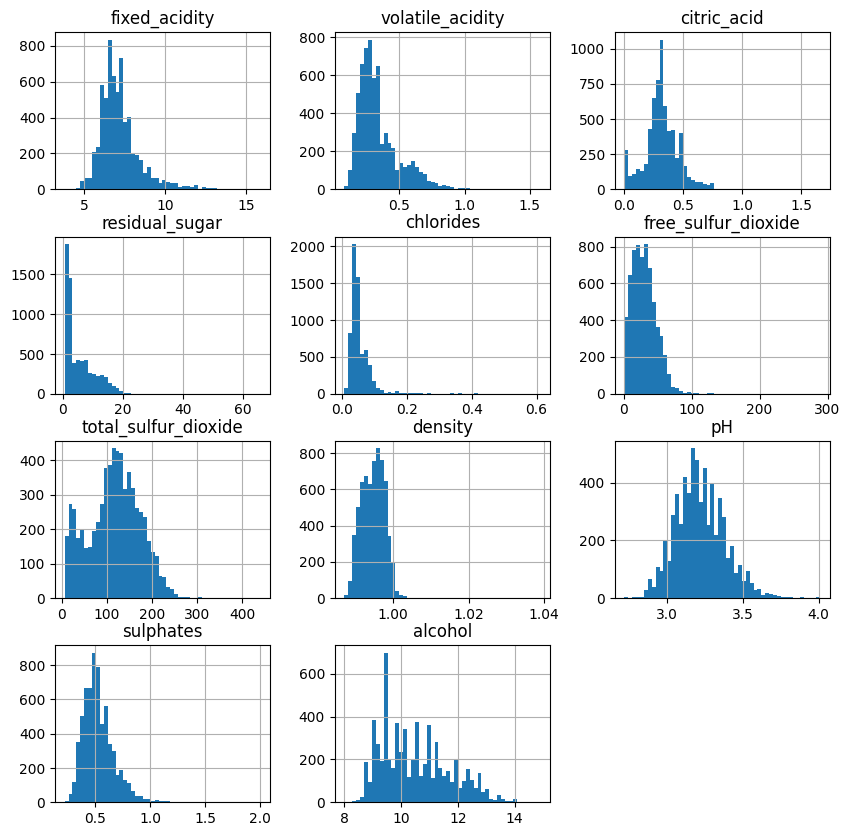

In [4]:
df.features.hist(figsize=(10,10),bins=50)
plt.show()

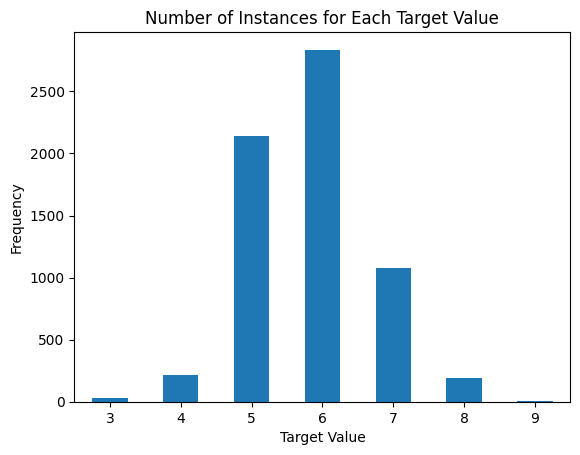

In [5]:
value_counts = df.targets.value_counts().sort_index()
# Plotting
ax = value_counts.plot(kind='bar')  # Plot the bar chart
# Format the x-axis labels
ax.set_xticklabels([x[0] for x in value_counts.index] )
plt.xlabel('Target Value')  # X-axis label
plt.ylabel('Frequency')      # Y-axis label
plt.title('Number of Instances for Each Target Value')  # Title of the plot
plt.xticks(rotation=0)
plt.show()


### Selekcija atributa

Selekcija atributa je tehnika koja omogućava odabir najboljeg skupa atributa za modeliranje i predviđanje. Cilj je identifikovati koji atributi donose najviše informacija i time poboljšati performanse modela.

Koristimo koeficijente korelacije između svih parova atributa u skupu podataka. Korelacija meri kako su atributi međusobno povezani:

Vrednost 1 označava jaku pozitivnu linearnu korelaciju, vrednost -1 označava jaku negativnu korelaciju dok vrednost 0 ukazuje na odsustvo korelacije, što znači da ne postoji značajna povezanost između atributa.

Na primer, atributi poput fiksne kiselosti i gustine imaju visoku korelaciju sa koeficijentom od 0.46, što sugeriše da su ti atributi značajno povezani. Nasuprot tome, atributi kao što su hloridi i koncentracija limunske kiseline imaju nižu korelaciju sa koeficijentom od 0.04, što znači da su manje povezani.

Razumevanje ovih korelacija može pomoći u optimizaciji modela tako što ćemo eliminisati redundantne ili manje korisne atributa.

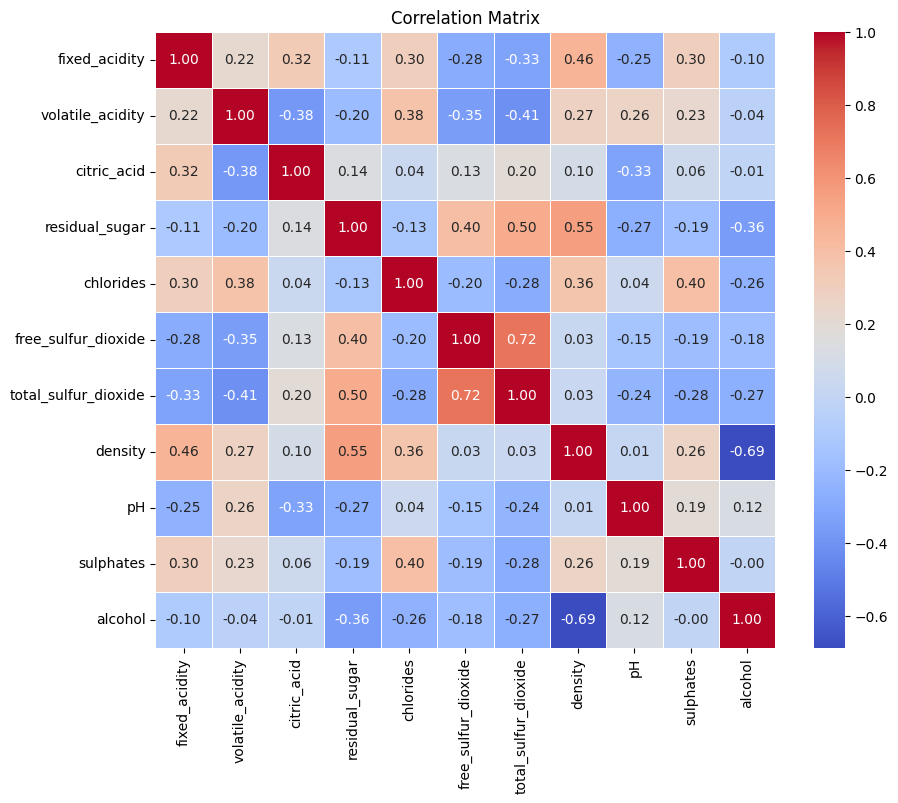

In [6]:
correlation_matrix = df.features.corr()
plt.figure(figsize=(10, 8))  # Set the figure size (optional)
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Pretprocesiranje podataka
### Podela podataka na skup za obučavanje i skup za testiranje
Na samom početku podatke delimo na skup za obučavanje i skup za testiranje koji sadrži 25% podataka i koji neće učestvovati u treniranju modela. 

In [31]:
# Podela na trening i test skup
X = df.features
y = df.targets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

## Standardizacija atributa
Sledeći korak je standardizacija atributa. Bitna napomena je da skalare za standardizaciju učimo na skupu za treniranje, dok skaliranje primenjujemo i na test skupu.

In [32]:
# Standardizacija atributa
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Redukcija dimenzionalnosti
Za sve metode koje ćemo koristiti, primenićemo tehniku redukcije dimenzionalnosti. Ova tehnika je korisna za smanjenje broja atributa u podacima, čime se poboljšava efikasnost modela, smanjuje složenost i potencijalno otklanjaju redudantni podaci. Dimenzija na koju ćemo redukovati podatke biće definisana kao hiperparametar modela, što znači da će se optimizovati tokom procesa obuke modela kako bi se postigao najbolji rezultat.

## Modeli

Na modelima linearne regresije, slučajne šume, svm, naive-bayes i adaboost-a ćemo unakrsnom validacijom na trening skupu naći najbolje hiperparametre, parametre i ocene rada modela. Na osnovu tih ocena, izabraćemo najbolji model i njega evaluirati konačno na test skupu.

Koristićemo PCA za smanjenje dimenzionalnosti podataka i GridSearchCV za optimizaciju modela, s obzirom na to da imamo ograničen broj podataka.

### Linearna regresija

In [33]:
#Hiperparametri
pipeline_lr = Pipeline([
    ('pca', PCA()),  
    ('regressor', linear_model.LinearRegression())
])

param_grid_lr = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
}

In [34]:
#Unakrsna validacija
grid_search_lr = model_selection.GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

best_model_lr = grid_search_lr.best_score_

print("Best score: ",best_model_lr)
print("Best parameters for Linear Regression: ", grid_search_lr.best_params_['pca__n_components'])

Best score:  -0.5393107445401897
Best parameters for Linear Regression:  11


### Naive-Bayes 

In [45]:
#Hiperparametri
pipeline_nb = Pipeline([
    ('pca', PCA()),  
    ('classifier', GaussianNB())
])

param_grid_nb = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
}

In [52]:
#Unakrsna validacija
grid_search_nb = model_selection.GridSearchCV(pipeline_nb, param_grid_nb, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_nb.fit(X_train, y_train)
best_model_nb = grid_search_nb.best_score_

print("Best score: ",best_model_nb)
print("Best parameters for Linear Regression: ", grid_search_nb.best_params_['pca__n_components'])

Best score:  -0.7327586206896552
Best parameters for Linear Regression:  8


## SVM

In [54]:
#Hiperparametri
pipeline_svm = Pipeline([
    ('pca', PCA()),  
    ('svr', SVR())
])

param_grid_svm = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5],
    'svr__gamma' : ['scale','auto']
}

In [55]:
#Unakrsna validacija
grid_search_svm = model_selection.GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)
best_model_svm = grid_search_svm.best_score_

print("Best score: ",best_model_svm)
print("Best parameters for Linear Regression: ", grid_search_svm.best_params_['pca__n_components'])

Best score:  -0.5305094063294825
Best parameters for Linear Regression:  10


## Slučajna šuma

In [56]:
#Hiperparametri
pipeline_rf = Pipeline([
    ('pca', PCA()),  
    ('regressor', RandomForestRegressor())
])

param_grid_rf = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'regressor__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'regressor__max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'regressor__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'regressor__min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
}

In [57]:
#Unakrsna validacija
grid_search_rf = model_selection.GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_model_rf = grid_search_rf.best_score_

print("Best score: ",best_model_rf)
print("Best parameters for Linear Regression: ", grid_search_rf.best_params_['pca__n_components'])

/home/miloje/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best score:  -0.40410492220291694
Best parameters for Linear Regression:  10


In [59]:
print(grid_search_rf.best_params_)

{'pca__n_components': 10, 'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}


## Adaboost

In [60]:
#Hiperparametri
pipeline_ab = Pipeline([
    ('pca', PCA()),  
    ('regressor', AdaBoostRegressor())
])

param_grid_ab = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'regressor__n_estimators': [50, 100, 200],  # Number of boosting stages
    'regressor__learning_rate': [0.01, 0.1, 1.0],  # Learning rate shrinks the contribution of each tree
}

In [61]:
#Unakrsna validacija
grid_search_ab = model_selection.GridSearchCV(pipeline_ab, param_grid_ab, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ab.fit(X_train, y_train)
best_model_ab = grid_search_ab.best_score_

print("Best score: ",best_model_ab)
print("Best parameters for Linear Regression: ", grid_search_ab.best_params_['pca__n_components'])

/home/miloje/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best score:  -0.5592594001320752
Best parameters for Linear Regression:  9


## Testiranje najboljeg modela
Model sa najboljim performansama je slučajna šuma. Hajde da testiramo uspešnost ovog modela na test skupu.

In [62]:
y_test_pred = grid_search_rf.predict(X_test)

In [79]:
def calculate_accuracy_with_tolerance(true_values, predictions, tolerance):
    true_values = np.array(true_values)
    predictions = np.array(predictions)
    return np.mean(np.abs(true_values - predictions) <= tolerance)

tolerances = np.linspace(0.1, 2.5, 50)
accuracies = [calculate_accuracy_with_tolerance(y_test, y_test_pred, tol) for tol in tolerances]

In [80]:
mae=metrics.mean_absolute_error(y_test, y_test_pred)
r2=metrics.r2_score(y_test, y_test_pred)
pc_used=grid_search_rf.best_params_['pca__n_components']
print("Mean absolute error: ", mae)
print("R2 score: ", rs)
print("Number of principal components used: ", pc_used)

Mean absolute error:  0.44944307692307695
R2 score:  0.4828275058303274
Number of principal components used:  10


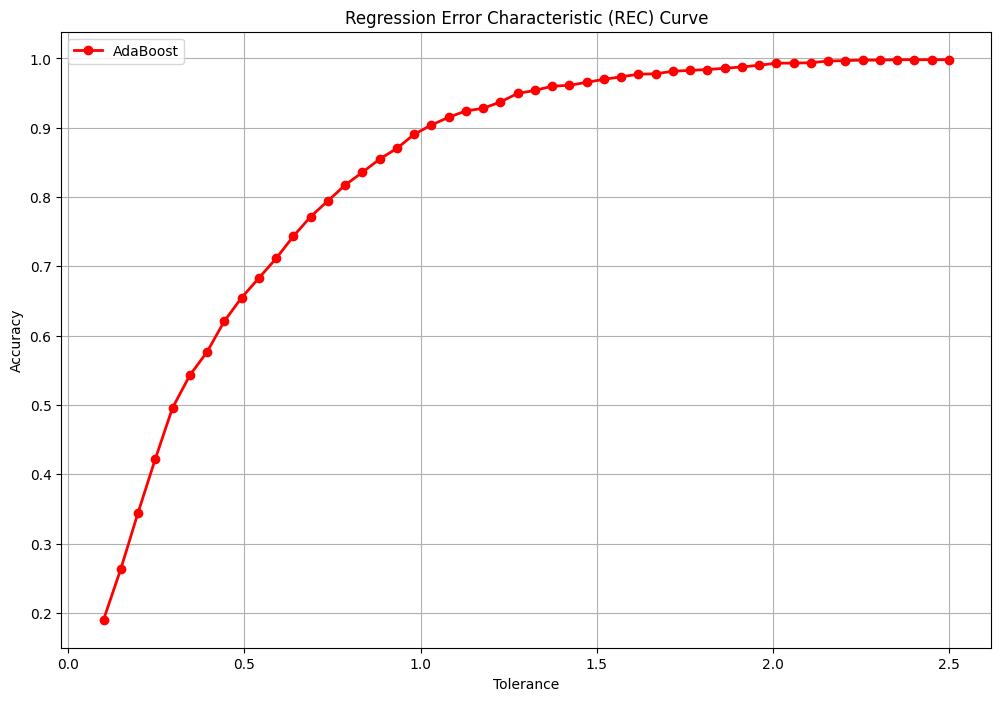

REC AUC for AdaBoost: 2.0405


In [83]:
plt.figure(figsize=(12, 8))
plt.plot(tolerances, accuracies, color='red', lw=2, marker='o', label='AdaBoost')
plt.xlabel('Tolerance')
plt.ylabel('Accuracy')
plt.title('Regression Error Characteristic (REC) Curve')
plt.grid(True)
plt.legend()
plt.show()


rec_auc_ab = np.trapz(accuracies, tolerances)
print(f"REC AUC for AdaBoost: {rec_auc_ab:.4f}")